# **WOD to CSIRO Ocean Data Archive**

This notebook deomstrates the proceedure for converting World Ocean Database (WOD) profiles in ragged array format to 
the CSIRO Ocean Data Archive (CODA) format. The basic steps are: 
- Download data from the Amazon Web Service (AWS) s3 bucket to a local machine;
- Add a "cast index" to the ragged array data to facilitate work on individual casts (also known as "profiles");
- Convert to CODA format and save to local disk

The local CODA format files are organised by observational platform (CTD, XBT, glider, profiling float, moored instrument, etc...), year and date. An individual file for each date, variable, and observing platform is produced to enable easy ingestion into data assimilation systems.



In [1]:
import xarray
import fsspec
import numpy as np
import s3fs
import proplot
import os

from matplotlib import pyplot as plt
import pandas

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [2]:
import sys
sys.path.append('/tube1/cha674/CARS_2022/cars-v2/wodpy/wodpy')
import wodnc

**Initiate the time period to interogate**\
Set the start and the end year (inclusive)

In [46]:
START_YEAR = 2005
END_YEAR   = 2006

**Download the data from the AWS S3 bucket**\
Requires the use of the s3 package. Download speeds are a bit slow, so this step could be improved.

In [9]:
obs_type = ['ctd','xbt','pfl'] #,'mrb','gld'] #,'drb'] #,'gld']
#obs_type = ['ctd']

base_s3_url = 's3://noaa-wod-pds'

data_container = {}

output_directory = '/tube1/cha674/CARS_2022_ancillary_data/WOD_2018'

for i_year in range(START_YEAR,END_YEAR+1):

    data_container_for_year = {}
    for i_obs_type in obs_type:
        url = base_s3_url + '/' + str(i_year) + '/wod_' + i_obs_type + '_' + str(i_year) + '.nc' #_pfl_2018.nc'
        print(url)
        fs = s3fs.S3FileSystem(anon=True)
        file_obj = fs.open(url)
        ds = xarray.open_dataset(file_obj,engine='h5netcdf')
        data_container_for_year[i_obs_type] = ds
        
        #Write data out
        if not os.path.isdir(os.path.join(output_directory,str(i_year))):
            os.mkdir(os.path.join(output_directory,str(i_year)))
        print(os.path.join(output_directory,str(i_year),'wod_' + i_obs_type + '_' + str(i_year) + '.nc'))
        ds.to_netcdf(os.path.join(output_directory,str(i_year),'wod_' + i_obs_type + '_' + str(i_year) + '.nc'))
        
    data_container[i_year] = data_container_for_year

s3://noaa-wod-pds/2010/wod_ctd_2010.nc
/tube1/cha674/CARS_2022_ancillary_data/WOD_2018/2010/wod_ctd_2010.nc
s3://noaa-wod-pds/2010/wod_xbt_2010.nc
/tube1/cha674/CARS_2022_ancillary_data/WOD_2018/2010/wod_xbt_2010.nc
s3://noaa-wod-pds/2010/wod_pfl_2010.nc
/tube1/cha674/CARS_2022_ancillary_data/WOD_2018/2010/wod_pfl_2010.nc
s3://noaa-wod-pds/2011/wod_ctd_2011.nc
/tube1/cha674/CARS_2022_ancillary_data/WOD_2018/2011/wod_ctd_2011.nc
s3://noaa-wod-pds/2011/wod_xbt_2011.nc
/tube1/cha674/CARS_2022_ancillary_data/WOD_2018/2011/wod_xbt_2011.nc
s3://noaa-wod-pds/2011/wod_pfl_2011.nc
/tube1/cha674/CARS_2022_ancillary_data/WOD_2018/2011/wod_pfl_2011.nc


**Read the WOD ragged array files from the local archive**\
It is better to download from AWS and then read locally, as performing operations on the remote dataset\
can be quite slow

In [ ]:
WOD_directory = '/oa-decadal-climate/work/observations/CARSv2_ancillary/WOD2018'
obs_type = ['ctd','xbt','pfl'] #,'mrb','gld'] #,'drb'] #,'gld']
data_container = {}

for i_year in range(START_YEAR,END_YEAR+1):
    data_container_for_year = {}
    for i_obs_type in obs_type:
        file_to_get = os.path.join(WOD_directory,str(i_year),'wod_' + i_obs_type + '_' + str(i_year) + '.nc')

        ds = xarray.open_dataset(file_to_get)  #,engine='h5netcdf')
        data_container_for_year[i_obs_type] = ds
        
        
    data_container[i_year] = data_container_for_year

In [36]:
ds = xarray.open_dataset(os.path.join(WOD_directory,str(i_year),file_name))

In [37]:
ds

<xarray.Dataset>
Dimensions:                         (casts: 25074, z_obs: 15400329, Temperature_obs: 15400329, Salinity_obs: 15363440, Oxygen_obs: 4539822, Pressure_obs: 10210343, Chlorophyll_obs: 2363471, numberofpis: 1768)
Coordinates:
    lat                             (casts) float32 ...
    lon                             (casts) float32 ...
    time                            (casts) datetime64[ns] ...
    z                               (z_obs) float32 ...
Dimensions without coordinates: casts, z_obs, Temperature_obs, Salinity_obs, Oxygen_obs, Pressure_obs, Chlorophyll_obs, numberofpis
Data variables: (12/88)
    country                         (casts) |S40 ...
    WOD_cruise_identifier           (casts) |S40 ...
    originators_cruise_identifier   (casts) |S40 ...
    wod_unique_cast                 (casts) int32 ...
    originators_station_identifier  (casts) |S40 ...
    date                            (casts) int32 ...
    ...                              ...
    Chlorophyll_Instrument          (casts) |S170 ...
    Chlorophyll_uncalibrated        (casts) float64 ...
    Primary_Investigator            (numberofpis) |S170 ...
    Primary_Investigator_VAR        (numberofpis) |S40 ...
    Primary_Investigator_row_size   (casts) float64 ...
    crs                             int32 ...
Attributes: (12/38)
    institution:                   National Centers for Environmental Informa...
    source:                        World Ocean Database
    references:                    World Ocean Database 2018. URL:http://data...
    title:                         World Ocean Database - Multi-cast file
    summary:                       Data for multiple casts from the World Oce...
    id:                            /nodc/data/OCLAB/OCL/retrieval/monthlies/w...
    ...                            ...
    history:                       
    license:                       
    standard_name_vocabulary:      CF Standard Name Table v41
    featureType:                   Profile
    cdm_data_type:                 Profile
    Conventions:                   CF-1.6

In [71]:
WOD_directory = '//oa-decadal-climate/work/observations/CARSv2_ancillary/WOD2018'
platforms_to_get = ['ctd']
WOD_file_name_stem = 'wod_'

profile_vars_to_get = ['Oxygen','Temperature','z']
point_vars_to_get   = ['lat','lon'] #,'time','wod_unique_cast']

for i_year in range(START_YEAR,END_YEAR+1):
    print(i_year)
    for i_platform in platforms_to_get:
        
        file_name  = WOD_file_name_stem + i_platform + '_' + str(i_year) + '.nc'
        WOD_ragged_object = wodnc.Ragged(os.path.join(WOD_directory,str(i_year),file_name))
        n_profiles = WOD_ragged_object.ncasts()
        
        max_depth_levels = 0
        
        for i_profile in range(0,n_profiles):
            
            WOD_profile_object = wodnc.ncProfile(WOD_ragged_object,i_profile)
            n_depth_levels  = WOD_profile_object.n_levels()
            
            if n_depth_levels>max_depth_levels:
                max_depth_levels = n_depth_levels
        
         
        #END for i_profile
        vars_in_dataset = list(WOD_ragged_object.variables().keys())
        
        profile_data_container = {}
        
        for i_var in profile_vars_to_get:
            if i_var in vars_in_dataset:

                profile_data_container[i_var] = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='float32')
                profile_data_container[i_var + '_WODflag'] = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='int8')
                profile_data_container[i_var + '_origflag'] = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='float32')
        #END for i_var

        point_data_container = {}
        for i_var in point_vars_to_get:
            point_data_container[i_var] = np.nan*np.zeros([n_profiles],dtype='float32')

        point_data_container['time'] = np.zeros([n_profiles],dtype='datetime64[ns]')
        point_data_container['wod_unique_cast'] = np.zeros([n_profiles],dtype='int32')

        for i_var in profile_vars_to_get:
            print(i_var)
            if i_var in vars_in_dataset:
            
                for i_profile in range(0,n_profiles):
                 
                    WOD_profile_object   = wodnc.ncProfile(WOD_ragged_object,i_profile)                
                    current_variable    = WOD_profile_object.level_unpack(i_var)
                
                    if current_variable.size != 0:
                        #Test for missing data on profile
                        profile_data_container[i_var][i_profile,0:current_variable.size] = current_variable
                        profile_data_container[i_var+'_WODflag'][i_profile,0:current_variable.size]  = WOD_profile_object.level_unpack(i_var+'_WODflag')
                        profile_data_container[i_var+'_origflag'][i_profile,0:current_variable.size] = WOD_profile_object.level_unpack(i_var+'_origflag')
                    
                    #END if current_variable.size != 0:
                #END for i_profile  
            #if i_var in vars_in_dataset:
        #END for i_var 
 
        for i_var in point_vars_to_get:
            if i_var in vars_in_dataset:
                for i_profile in range(0,n_profiles):
         
                    WOD_profile_object   = wodnc.ncProfile(WOD_ragged_object,i_profile)                
                    point_data_container[i_var][i_profile] = WOD_profile_object.metadata(i_var)
                
                    point_data_container['wod_unique_cast'][i_profile] = WOD_profile_object.metadata('wod_unique_cast')
                    point_data_container['time'][i_profile] = np.datetime64(WOD_profile_object.datetime())

                #END for i_profile
            #END if i_var in vars_in_dataset
        #END for i_var in point_vars_to_get
        
        
        cast_index = np.arange(1,n_profiles+1)
        
        
        
        CODA_output_dataset = xarray.DataArray(point_data_container['wod_unique_cast'],dims=['cast'],coords={'cast':cast_index}).to_dataset(name='WOD_id') #attrs = attribute_container_for_year['lat']
        #                                         ).to_dataset(name='latitude')
        
        CODA_output_dataset['time'] = xarray.DataArray(point_data_container['time'],dims=['cast'],coords={'cast':cast_index})
        CODA_output_dataset['time'].encoding['units'] = 'seconds since 1980-01-01'
        CODA_output_dataset['lat'] = xarray.DataArray(point_data_container['lat'],dims=['cast'],coords={'cast':cast_index})
        CODA_output_dataset['lon'] = xarray.DataArray(point_data_container['lon'],dims=['cast'],coords={'cast':cast_index})

        

        for i_var in profile_data_container.keys():
            CODA_output_dataset[i_var]  = xarray.DataArray(profile_data_container[i_var],dims=['cast','z_index'],
                                                            coords= {'cast':cast_index,'z_index':np.arange(0,max_depth_levels,1)},
                                                            )
 
        
        #CODA_output_dataset   = xarray.DataArray(point_data_container['lat'],dims=['cast'],coords={'cast':cast_index}, #attrs = attribute_container_for_year['lat']
        #                                         ).to_dataset(name='latitude')
    
        #attrs = attribute_container_for_year[i_var]
        #CODA_output_dataset['longitude']  = xarray.DataArray(AIMS_longitude[idx_for_year][idx_time_sort],dims=['cast'],coords={'cast':cast_index},
        #                                                 attrs = attribute_container_for_year['lon'])
        #attrs = attribute_container_for_year['time']
        #CODA_output_dataset['time']       = xarray.DataArray(pandas.to_datetime(AIMS_date)[idx_for_year][idx_time_sort],dims=['cast'],coords={'cast':cast_index},
        #                                                 attrs = attribute_container_for_year['time'])
        
        dsada
        
        
    #END for i_platform
#END for i_year


2005
Oxygen
Temperature
z


NameError: name 'dsada' is not defined

(0, 300)

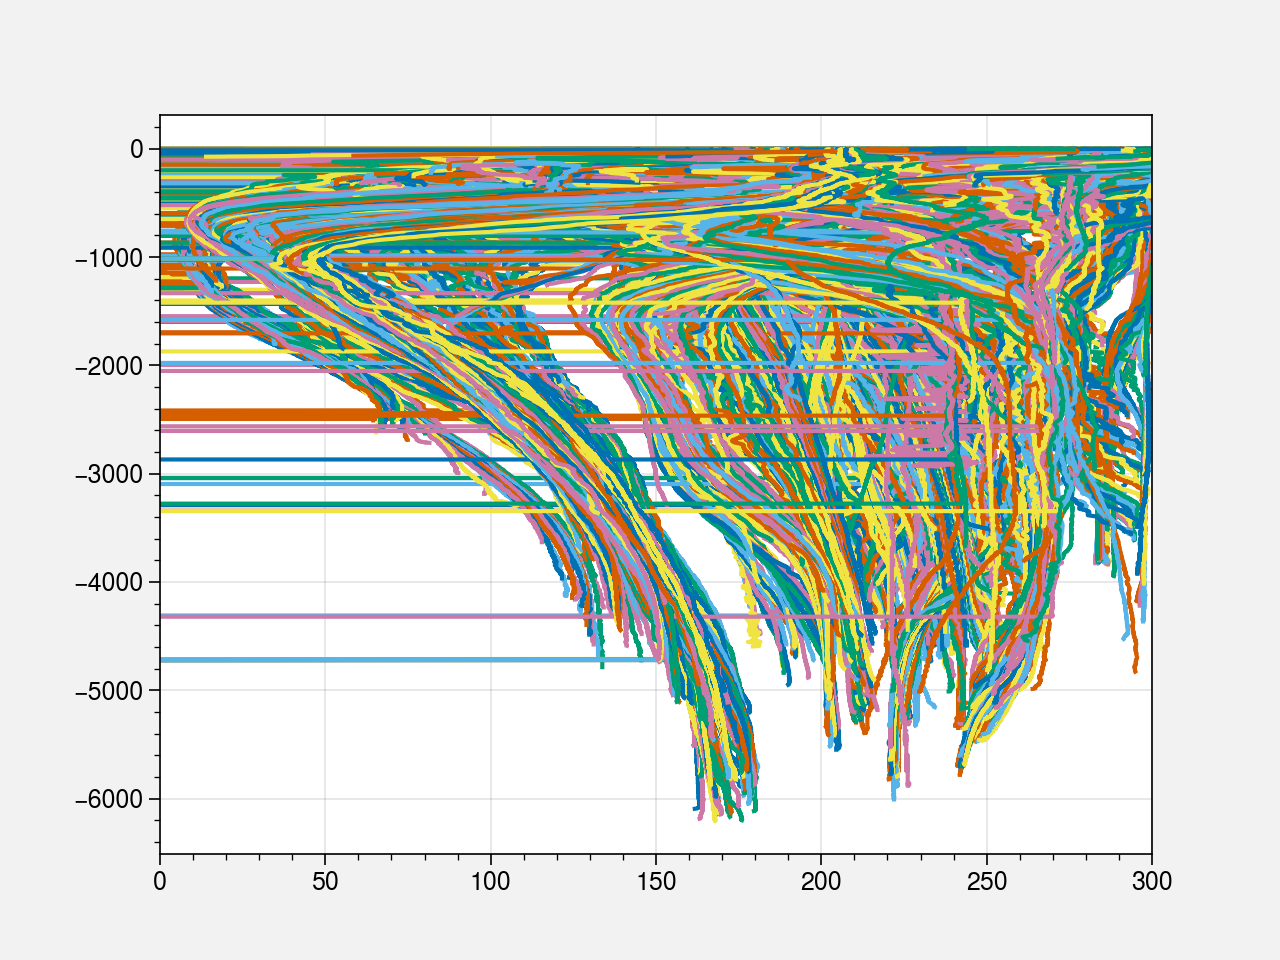

In [82]:
    plt.plot(CODA_output_dataset['Oxygen'].T,-CODA_output_dataset['z'].T)
    plt.xlim([0,300])

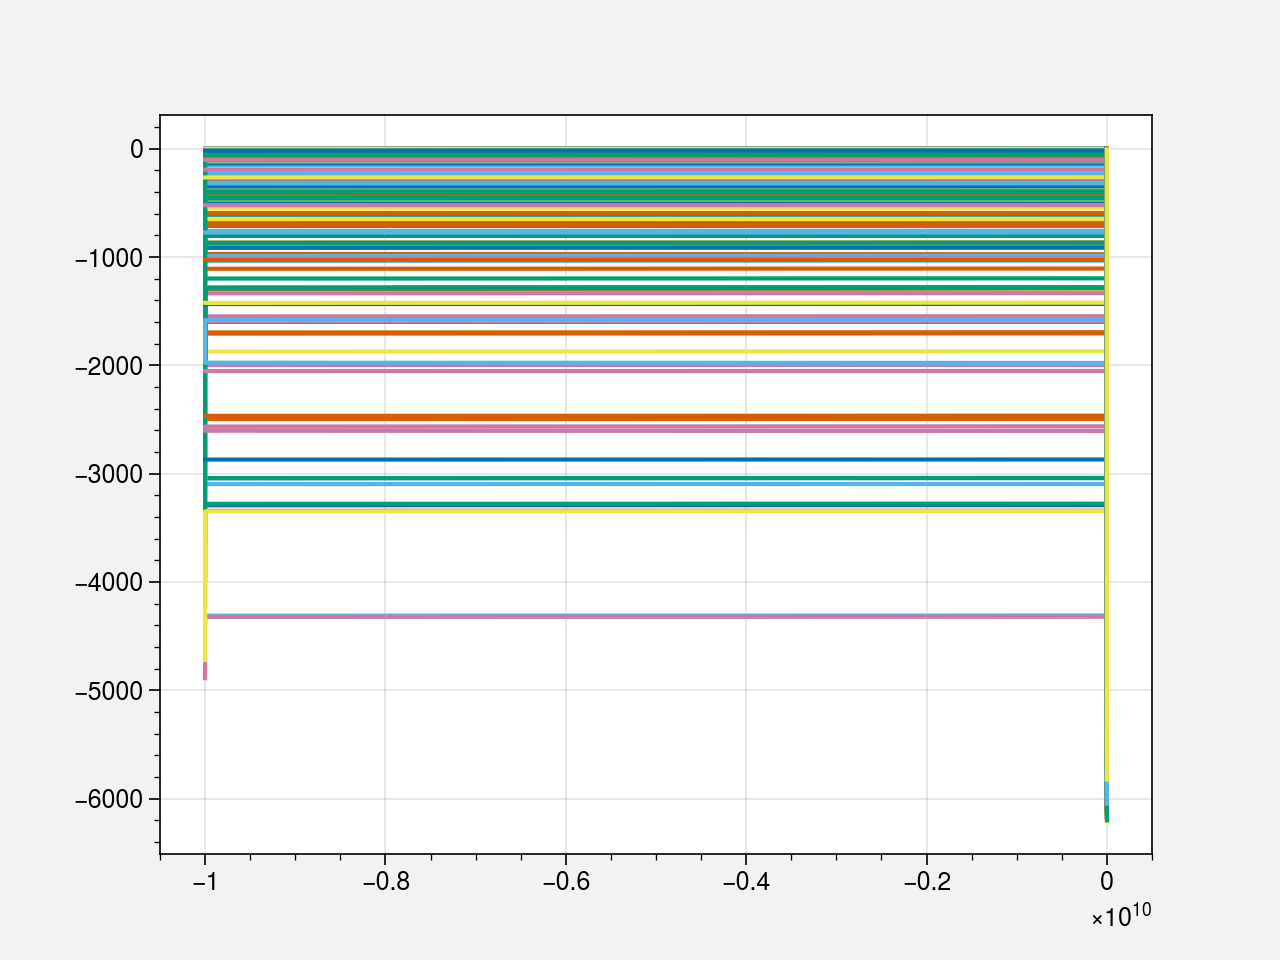

In [81]:
for i_cast in range(0,CODA_output_dataset['cast'].size):



In [70]:
CODA_output_dataset = xarray.DataArray(point_data_container['wod_unique_cast'],dims=['cast'],coords={'cast':cast_index}).to_dataset(name='WOD_id') #attrs = attribute_container_for_year['lat']
        #                                         ).to_dataset(name='latitude')
        
CODA_output_dataset['time'] = xarray.DataArray(point_data_container['time'],dims=['cast'],coords={'cast':cast_index})
CODA_output_dataset['time'].encoding['units'] = 'seconds since 1980-01-01'
CODA_output_dataset['lat'] = xarray.DataArray(point_data_container['lat'],dims=['cast'],coords={'cast':cast_index})
CODA_output_dataset['lon'] = xarray.DataArray(point_data_container['lon'],dims=['cast'],coords={'cast':cast_index})

for i_var in profile_vars_to_get.keys():
    CODA_output_dataset[i_var]  = xarray.DataArray(profile_data_container[i_var],dims=['cast','z_index'],
                                                            coords= {'cast':cast_index,'z_index':np.arange(0,max_depth_levels,1)},
                                                            )
 
        

AttributeError: 'list' object has no attribute 'keys'

In [69]:
CODA_output_dataset

(<xarray.Dataset>
 Dimensions:  (cast: 26194)
 Coordinates:
   * cast     (cast) int64 1 2 3 4 5 6 7 ... 26189 26190 26191 26192 26193 26194
 Data variables:
     WOD_id   (cast) int32 15076949 15076950 11192070 ... 15077332 15077333,)

In [34]:
current_temp

array([12.792, 13.085, 12.729, 12.778, 12.538, 12.454, 12.382, 12.293,
       12.261, 12.229, 12.167, 12.121, 11.732, 11.333, 11.29 , 11.468,
       11.401, 11.267, 10.955, 10.734, 10.701, 10.599, 10.601, 10.693,
       10.834, 10.868, 10.894, 10.782, 10.671, 10.493, 10.419, 10.235,
        9.878,  9.995,  9.957,  9.821,  9.854,  9.945,  9.924,  9.814,
        9.7  ,  9.647,  9.601,  9.492,  9.469,  9.469,  9.463,  9.447,
        9.449,  9.457,  9.426,  9.421,  9.38 ,  9.354,  9.275,  9.244,
        9.22 ,  9.207,  9.174,  9.126,  9.013,  8.96 ,  8.921,  8.874,
        8.846,  8.799,  8.777,  8.739,  8.724,  8.707,  8.688,  8.676,
        8.66 ,  8.646,  8.649,  8.65 ,  8.661,  8.663,  8.654,  8.614,
        8.601,  8.594,  8.584,  8.558,  8.553,  8.551,  8.524,  8.48 ,
        8.465,  8.449,  8.424,  8.399,  8.392,  8.391,  8.388,  8.386,
        8.381,  8.388,  8.374,  8.36 ,  8.36 ,  8.351,  8.339,  8.33 ,
        8.326,  8.319,  8.312,  8.27 ,  8.149,  8.304,  8.15 ,  8.118,
      

In [28]:
                current_variable    = WOD_profile_object.level_unpack(i_var)


**Add the cast index to the WOD data container**\
WOD ragged array format is organised as follows:
- Individual casts each with a "row size" variable
- A (potentially long) data array of all individual cast data values concatenated together

For each data variable (temperature, salinity, pressure, etc...) we add a simple, unique "cast index". 
This step is relatively slow and could probably be multi-processed, as each cast is treated separately

In [11]:
variable_names = ['Temperature','Pressure','Salinity','Oxygen'] #Oxygen
WOD_directory = '/tube1/cha674/CARS_2022_ancillary_data/WOD_2018'


for i_year in range(START_YEAR,END_YEAR+1):
    year_index = i_year-START_YEAR
    print('Working on year: ', i_year)
    for i_obs_type in obs_type:

        print('Working on observational platform: ', i_obs_type)
        for i_var in variable_names:
            print('Working on variable: ', i_var)
            cast_temperature_index = create_profile_index(data_container[i_year][i_obs_type],i_var)
            
            data_container[i_year][i_obs_type][i_var + '_cast_index']    = cast_temperature_index
            
        cast_depth_index       = create_profile_index(data_container[i_year][i_obs_type],'z')
        data_container[i_year][i_obs_type]['z_cast_index']           = cast_depth_index
        

Working on year:  2010
Working on observational platform:  ctd
Working on variable:  Temperature
Working on variable:  Pressure
Working on variable:  Salinity
Working on variable:  Oxygen
Working on observational platform:  xbt
Working on variable:  Temperature
Working on variable:  Pressure
Working on variable:  Salinity
Working on variable:  Oxygen
Working on observational platform:  pfl
Working on variable:  Temperature
Working on variable:  Pressure
Working on variable:  Salinity
Working on variable:  Oxygen
Working on year:  2011
Working on observational platform:  ctd
Working on variable:  Temperature
Working on variable:  Pressure
Working on variable:  Salinity
Working on variable:  Oxygen
Working on observational platform:  xbt
Working on variable:  Temperature
Working on variable:  Pressure
Working on variable:  Salinity
Working on variable:  Oxygen
Working on observational platform:  pfl
Working on variable:  Temperature
Working on variable:  Pressure
Working on variable:  Sa

In [ ]:
CODA_form_data_container = {}

obs_type = ['ctd','xbt','pfl']
for i_year in range(START_YEAR,END_YEAR+1):
    year_index = i_year-START_YEAR
    print(i_year)
    CODA_form_data_container_for_year = {}

    
    for i_obs_type in obs_type:
        print(i_obs_type)
        
        CODA_form_data_container_for_obs_type = {}
        for i_var in variable_names:
            print('variable:', i_var)
            if i_var in data_container[i_year][i_obs_type].data_vars or i_var=='z':
                
                #Get the cast indicies for the current variable
                data_cast_index       = data_container[i_year][i_obs_type][i_var + '_cast_index']
                unique_cast_identifer = np.unique(data_cast_index)

                #Intialize the maximum length
                max_length_profile = 0
            
                #Test to find the max length of any individual profile.
                #NOTE max length and max depth are not the same, particularly
                #for hydrographic (bottle) data
                for i_cast in unique_cast_identifer:
                
                    #Get length of current profile
                    length_profile = (data_cast_index.values==i_cast).sum()
                
                    #is current length greater than the max length?
                    if length_profile>max_length_profile:
                        max_length_profile = length_profile
            
                #END for i_cast
                
                #Initialize CODA data arrays
                data_array  = np.zeros([unique_cast_identifer.size,max_length_profile],dtype='float32')
                depth_array = np.zeros([unique_cast_identifer.size,max_length_profile],dtype='float32')
                depth_array = np.zeros([unique_cast_identifer.size,max_length_profile],dtype='float32')

                data_WOD_flag_array  = np.zeros([unique_cast_identifer.size,max_length_profile],dtype='int8')
                depth_WOD_flag_array = np.zeros([unique_cast_identifer.size,max_length_profile],dtype='int8')

                
                cast_ID         = np.zeros([unique_cast_identifer.size],dtype='int32')
                latitude_array  = np.zeros([unique_cast_identifer.size],dtype='float32')
                longitude_array = np.zeros([unique_cast_identifer.size],dtype='float32')
                time_array      = np.zeros([unique_cast_identifer.size],dtype='datetime64[ns]')
                

        
                #Assign 
                for i_cast in range(0,len(unique_cast_identifer)):
                    i_cast_index = np.nonzero(data_cast_index.values==unique_cast_identifer[i_cast])[0]
                    
                    depth_obs    =  data_container[i_year][i_obs_type]['z'][i_cast_index]
                    data_obs     =  data_container[i_year][i_obs_type][i_var][i_cast_index]
                    
                    if 'z_WODflag' in data_container[i_year][i_obs_type].data_vars:
                        depth_flag   = data_container[i_year][i_obs_type]['z_WODflag'][i_cast_index]
                        depth_WOD_flag_array[i_cast,0:depth_obs.size] = depth_flag
                    if i_var + '_WODflag' in data_container[i_year][i_obs_type].data_vars:
                        data_flag    = data_container[i_year][i_obs_type][i_var + '_WODflag'][i_cast_index]
                        data_WOD_flag_array[i_cast,0:data_obs.size]   = data_flag
                     #Temperature_WODflag

                    
                    data_array[i_cast,0:data_obs.size]   = data_obs
                    depth_array[i_cast,0:depth_obs.size] = depth_obs

                    data_array[i_cast,data_obs.size::]   = np.nan
                    depth_array[i_cast,depth_obs.size::] = np.nan

                
                    cast_ID[i_cast]          = data_container[i_year][i_obs_type]['wod_unique_cast'][unique_cast_identifer[i_cast]]
                    latitude_array[i_cast]   = data_container[i_year][i_obs_type]['lat'][unique_cast_identifer[i_cast]]
                    longitude_array[i_cast]  = data_container[i_year][i_obs_type]['lon'][unique_cast_identifer[i_cast]]
                    time_array[i_cast]       = data_container[i_year][i_obs_type]['time'][unique_cast_identifer[i_cast]].values
                    
                #END for i_cast
                
                CODA_form_data_container_for_obs_type[i_var + '_data']            = data_array
                CODA_form_data_container_for_obs_type[i_var + '_depth']           = depth_array
                CODA_form_data_container_for_obs_type[i_var + '_data_WODflag']    = data_WOD_flag_array
                CODA_form_data_container_for_obs_type[i_var + '_depth_WOD_flag']  = depth_WOD_flag_array
            
                CODA_form_data_container_for_obs_type[i_var + '_lat']             = latitude_array
                CODA_form_data_container_for_obs_type[i_var + '_lon']             = longitude_array
                CODA_form_data_container_for_obs_type[i_var + '_time']            = time_array
                CODA_form_data_container_for_obs_type[i_var + '_wod_unique_cast'] = cast_ID

            else:
                print(i_var, ' not found, skipping')
                continue 
            #END     
            
            #CODA_form_data_container_for_obs_type[i_var + '_depth_WOD_flag'] = depth_WOD_flag_array

        #END i_var
        CODA_form_data_container_for_year[i_obs_type] = CODA_form_data_container_for_obs_type
        
        
    #END i_obs
    
    CODA_form_data_container[i_year] = CODA_form_data_container_for_year
#END i_year

2010
ctd
variable: Temperature
variable: Pressure


In [28]:
for i_year in range(START_YEAR,END_YEAR+1):
    year_index = i_year-START_YEAR
    print(i_year)
    CODA_form_data_container_for_year = CODA_form_data_container[i_year]
        
    
    
    for i_obs_type in obs_type:
        
        print(i_obs_type)
        
        #output_file_path_current_year = os.path.join(output_file_path,str(i_year),i_obs_type)

        #if not os.path.isdir(output_file_path_current_year):
        #    os.makedirs(output_file_path_current_year)

        
        CODA_form_data_container_for_obs_type = CODA_form_data_container_for_year[i_obs_type]
        dsa
        
        

2010
ctd


NameError: name 'dsa' is not defined

In [35]:
CODA_form_data_container[2010]['xbt']['Temperature_depth'].shape

(21174, 3561)

In [27]:
obs_type = ['ctd','xbt','pfl']

output_file_path = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/WOD'
for i_year in range(START_YEAR,END_YEAR+1):
    year_index = i_year-START_YEAR
    print(i_year)
    CODA_form_data_container_for_year = CODA_form_data_container[i_year]
        
    
    
    for i_obs_type in obs_type:
        
        print(i_obs_type)
        
        output_file_path_current_year = os.path.join(output_file_path,str(i_year),i_obs_type)

        if not os.path.isdir(output_file_path_current_year):
            os.makedirs(output_file_path_current_year)

        
        CODA_form_data_container_for_obs_type = CODA_form_data_container_for_year[i_obs_type]
        
        
        for i_var in variable_names:
            if i_var + '_data' in CODA_form_data_container_for_obs_type.keys() or i_var=='z':
                print(i_var)
                
                
                #print(CODA_form_data_container_for_obs_type[ i_var + '_data'])
                
                CODA_output_dataset = xarray.DataArray(CODA_form_data_container_for_obs_type[ i_var + '_data'],
                                                     dims=['cast','depth_index'],
                                                     coords={'cast':CODA_form_data_container_for_obs_type[i_var + '_wod_unique_cast'],
                                                             'depth_index':np.arange(0,CODA_form_data_container_for_obs_type[ i_var + '_data'].shape[1],1)}).to_dataset(name=i_var + '_data')
                CODA_output_dataset[i_var + '_depth'] = xarray.DataArray(CODA_form_data_container_for_obs_type[i_var + '_depth'],
                                                     dims=['cast','depth_index'],
                                                     coords={'cast':CODA_form_data_container_for_obs_type[i_var + '_wod_unique_cast'],
                                                             'depth_index':np.arange(0,CODA_form_data_container_for_obs_type[ i_var + '_data'].shape[1],1)})
                CODA_output_dataset[i_var + '_data_WODflag'] = xarray.DataArray(CODA_form_data_container_for_obs_type[i_var + '_data_WODflag'],
                                                     dims=['cast','depth_index'],
                                                     coords={'cast':CODA_form_data_container_for_obs_type[i_var + '_wod_unique_cast'],
                                                             'depth_index':np.arange(0,CODA_form_data_container_for_obs_type[ i_var + '_data'].shape[1],1)})
                CODA_output_dataset[i_var + '_depth_WOD_flag'] = xarray.DataArray(CODA_form_data_container_for_obs_type[i_var + '_depth_WOD_flag'],
                                                     dims=['cast','depth_index'],
                                                     coords={'cast':CODA_form_data_container_for_obs_type[i_var + '_wod_unique_cast'],
                                                             'depth_index':np.arange(0,CODA_form_data_container_for_obs_type[ i_var + '_data'].shape[1],1)})

                CODA_output_dataset['lat'] = xarray.DataArray(CODA_form_data_container_for_obs_type[i_var + '_lat'],
                                                     dims=['cast'],coords={'cast':CODA_form_data_container_for_obs_type[i_var + '_wod_unique_cast']})
                CODA_output_dataset['lon'] = xarray.DataArray(CODA_form_data_container_for_obs_type[i_var + '_lon'],
                                                            dims=['cast'],coords={'cast':CODA_form_data_container_for_obs_type[i_var + '_wod_unique_cast']})
                CODA_output_dataset['time'] = xarray.DataArray(CODA_form_data_container_for_obs_type[i_var + '_time'],
                                                            dims=['cast'],coords={'cast':CODA_form_data_container_for_obs_type[i_var + '_wod_unique_cast']})
                
                CODA_output_dataset['time'].encoding['units'] = 'seconds since 1980-01-01'

                
                
                daily_date_range = np.arange(np.datetime64(str(i_year) + '-01-01'),np.datetime64(str(i_year+1) + '-01-02'),np.timedelta64(1,'D'))
              
                for i_date in range(0,len(daily_date_range)-1):
                    current_date = daily_date_range[i_date] 
                    next_date    = daily_date_range[i_date+1] #.astype('str')
                    
                    
                    idx_time = np.nonzero(np.logical_and( CODA_output_dataset['time'].values>=current_date,
                                                          CODA_output_dataset['time'].values <next_date     ))[0]
                    #date_string = current_date.dt.strftime('%m/%d/%Y')
                    #print(current_date.astype('str'))
                    
                    daily_output_file_name = 'CODA_WOD_' + i_obs_type + '_' + i_var + '_' + current_date.astype('str') + '.nc'
                    
                    daily_CODA_output_dataset = CODA_output_dataset.isel(cast=idx_time)
                    
                    
                    
                    
                
                    #print('Writing output:', os.path.join(output_file_path_current_year,daily_output_file_name))
                
                    daily_CODA_output_dataset.to_netcdf(os.path.join(output_file_path_current_year,daily_output_file_name))
            

2010
ctd
Temperature
Pressure
Salinity
Oxygen
xbt
Temperature
pfl
Temperature
Pressure
Salinity
Oxygen
2011
ctd
Temperature
Pressure
Salinity
Oxygen
xbt
Temperature
pfl
Temperature
Pressure
Salinity
Oxygen


In [25]:
daily_date_range

array(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
       '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
       '2011-01-09', '2011-01-10', '2011-01-11', '2011-01-12',
       '2011-01-13', '2011-01-14', '2011-01-15', '2011-01-16',
       '2011-01-17', '2011-01-18', '2011-01-19', '2011-01-20',
       '2011-01-21', '2011-01-22', '2011-01-23', '2011-01-24',
       '2011-01-25', '2011-01-26', '2011-01-27', '2011-01-28',
       '2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
       '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
       '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09',
       '2011-02-10', '2011-02-11', '2011-02-12', '2011-02-13',
       '2011-02-14', '2011-02-15', '2011-02-16', '2011-02-17',
       '2011-02-18', '2011-02-19', '2011-02-20', '2011-02-21',
       '2011-02-22', '2011-02-23', '2011-02-24', '2011-02-25',
       '2011-02-26', '2011-02-27', '2011-02-28', '2011-03-01',
       '2011-03-02', '2011-03-03', '2011-03-04', '2011-